Our own DEG analysis for Chen et al., (2020).  From their text they had several adhoc steps and refused to publish or share code.  Relevant publication: [Law, Charity W., Kathleen Zeglinski, Xueyi Dong, Monther Alhamdoosh, Gordon K. Smyth, and Matthew E. Ritchie. "A guide to creating design matrices for gene expression experiments." F1000Research 9 (2020).](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7873980/) also see the [Limma User Guide](https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf).  Section 9.5 in particular has an explanation of making contrasts for interaction terms which could be usefull.  The text for the voom transformation is informative for the more technical details of the analysis: http://www.statsci.org/smyth/pubs/VoomPreprint.pdf
<br>
This publication maybe interesting as well: https://www.nature.com/articles/s41467-021-25960-2  
<br>
This may also be useful: https://github.com/hbc/knowledgebase/blob/master/scrnaseq/pseudobulkDE_edgeR.md

In [1]:
library(randomForest)
library(rfUtilities)
library(stringr)
library(sampler)
library(caTools)
library(pROC)
library(ggplot2)
library(stats)
library(Dict)
library(pheatmap)
library(caret)
library(data.table)
library(dplyr)
library(lme4)
library(edgeR)
library(tictoc)
library(factoextra)
library(FactoMineR)

randomForest 4.7-1.1

Type rfNews() to see new features/changes/bug fixes.

Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var



Attaching package: 'ggplot2'


The following object is masked from 'package:randomForest':

    margin


Loading required package: lattice


Attaching package: 'dplyr'


The following objects are masked from 'package:data.table':

    between, first, last


The following object is masked from 'package:randomForest':

    combine


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union


Loading required package: Matrix

Loading required package: limma

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa



In [2]:
# Functions

# normalization functions
pseudocount_log2p1_transform <- function(x, scale_factor = 10^6, UMI.provided = NULL){
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x+1)/counts
  x <- x/scale_factor
  return(log2(x))
}

pavlab.normalize <- function(df, UMI = NULL){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
#
   df[] <- Map(pseudocount_log2p1_transform, df, UMI.provided = UMI)
  
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}


# to write pheatmap images to file as a .png
save_pheatmap <- function(x, filename, width=480, height=960) {
   stopifnot(!missing(x))
   stopifnot(!missing(filename))
   png(filename,width = width, height=height)
   grid::grid.newpage()
   grid::grid.draw(x$gtable)
   dev.off()
}

In [3]:
# file paths 

chencounts.path <- '~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/GSE152632_GEO_mberkchen_TRAP2_counts.csv.gz'
chenmeta.path <- '~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/SraRunTable.txt'
chenclsutermarkers.formeta.path <- "~/PavLabEngrams/EngramCellClassifier/Chen2020_GSE152632/Chen2020_ClusterMarkers.csv"
humanmouseorthologtable.path <- "/home/acampbell/PavLabEngrams/EngramCellClassifier/hg_mm_1to1_ortho_genes_DIOPT-v8.tsv"

In [4]:
#Chen
chen2020_counts <- read.csv(chencounts.path , header = TRUE)
rownames(chen2020_counts) <- chen2020_counts$X
chen2020_counts <- chen2020_counts[,2:3531]
chen2020_meta <- read.csv( chenmeta.path , header = TRUE)

#add engram label
chen2020_meta$engram_label <-  as.factor(sapply(as.character(colnames(chen2020_counts)), function(y) if (grepl("_pos_", y, fixed=TRUE)) "tdT+" else "tdT-"))

#create the condition label
condition_label <- chen2020_meta$source_name %>%
  sapply( function(y) if (grepl("Homecage", y, fixed=TRUE)) "Homecage")

condition_label <- chen2020_meta$source_name
condition_label[str_detect(condition_label, "Homecage")] = "Homecage"
condition_label[str_detect(condition_label, "Context-Only")] = "Context-Only"
condition_label[str_detect(condition_label, "Fear-Only")] = "Fear-Only"
condition_label[str_detect(condition_label, "Fear-Recall")] = "Fear-Recall"
chen2020_meta$condition_label <- condition_label

#adding cell bacrcodes from coutn data to rows of metadata for seurat
rownames(chen2020_meta) <- colnames(chen2020_counts)


chen2020_meta <- cbind(chen2020_meta, read.csv(chenclsutermarkers.formeta.path) )
         
###

In [5]:
# gene filtering
# Filter out rows with less than 10 columns with values greater than 1
chen.genefilter <- rowSums(chen2020_counts > 0) >= 10 # removes about 3k genes, use it later (not at cell level)
chen.cellfilter <- (colSums(chen2020_counts) > 50000) | (colSums(chen2020_counts > 0) >= 100) # doesn't change anything I think they only reported cells that passed this filter

In [6]:
# we are only interested in genes with human orthologs anyway
# we also only want protien coding genes so this may help
hg_to_mm <- read.table(humanmouseorthologtable.path , sep = '\t', header = TRUE)


In [7]:
# to preserve the original data
chen_og <- chen2020_counts
#chen2020_counts <- chen_og
# now we filter
#chen2020_counts <- chen2020_counts[chen.genefilter,chen.cellfilter ] # do this later after we pseudobulk to do cor() on samples
chen2020_counts <- chen2020_counts[,chen.cellfilter ]
chen2020_meta <- chen2020_meta[chen.cellfilter ,]

In [8]:
# Create a list to store the masks
masks <- list()

# Iterate through each unique combination of source_name, broad_cell_types, and engram_label
for (i in unique(chen2020_meta$source_name)) {
  for (j in unique(chen2020_meta$BroadCellTypes)) {
    for (k in unique(chen2020_meta$engram_label)) {
      # Create a boolean mask for each unique combination
      mask <- chen2020_meta$source_name == i & chen2020_meta$BroadCellTypes == j & chen2020_meta$engram_label == k
      print(sum(mask))
      # Name the mask after the unique combination
      name <- paste(i, j, k, sep = "_")
      print(name)
      # Store the mask in the list
      masks[[name]] <- mask
      # Print the name of the mask
    }
  }
}


[1] 32
[1] "m5_Homecage_Excitatory_tdT-"
[1] 65
[1] "m5_Homecage_Excitatory_tdT+"
[1] 9
[1] "m5_Homecage_Inhibitory_tdT-"
[1] 28
[1] "m5_Homecage_Inhibitory_tdT+"
[1] 55
[1] "m5_Context-Only_Excitatory_tdT-"
[1] 39
[1] "m5_Context-Only_Excitatory_tdT+"
[1] 10
[1] "m5_Context-Only_Inhibitory_tdT-"
[1] 1
[1] "m5_Context-Only_Inhibitory_tdT+"
[1] 61
[1] "m2_Context-Only_Excitatory_tdT-"
[1] 101
[1] "m2_Context-Only_Excitatory_tdT+"
[1] 16
[1] "m2_Context-Only_Inhibitory_tdT-"
[1] 35
[1] "m2_Context-Only_Inhibitory_tdT+"
[1] 113
[1] "m2_Fear-Only_Excitatory_tdT-"
[1] 94
[1] "m2_Fear-Only_Excitatory_tdT+"
[1] 33
[1] "m2_Fear-Only_Inhibitory_tdT-"
[1] 6
[1] "m2_Fear-Only_Inhibitory_tdT+"
[1] 31
[1] "m1_Fear-Recall_Excitatory_tdT-"
[1] 43
[1] "m1_Fear-Recall_Excitatory_tdT+"
[1] 26
[1] "m1_Fear-Recall_Inhibitory_tdT-"
[1] 75
[1] "m1_Fear-Recall_Inhibitory_tdT+"
[1] 8
[1] "m1_Fear-Only_Excitatory_tdT-"
[1] 11
[1] "m1_Fear-Only_Excitatory_tdT+"
[1] 4
[1] "m1_Fear-Only_Inhibitory_tdT-"
[1] 13
[1

In [9]:
#we need to reorder these masks for later down the line for plotting purposes

reorder_str_vector <- function(string_vec, order_by_these_substrings){
    # string vec is a list of strings
    # order_by_these_substrings is the lsit of substrings to search for in the 
    # string_vec and to group together 
    # returns a new string vector grouped and ordered with any character strings not containing the substrings of interest removed
    # so in a list of reddog, redcat,bluedog,purplecat, greeparrot, yellowdog if you provide the substrings c('cat','dog')
    # you search would return  c('redcat','purplecat','reddog','bluedog','yellowdog')
    
    modified_string_vec <- c()
    
    for (substring in order_by_these_substrings){
        modified_string_vec <- c(modified_string_vec, string_vec[grepl(substring,string_vec, fixed = T)])
        }
    return(modified_string_vec)
    }

condition_order <- c('Fear-Recall','Fear-Only','Context-Only','Homecage')

reorderdnames <- c( reorder_str_vector(names(masks)[grepl('tdT+',names(masks), fixed = T)], condition_order),
                    reorder_str_vector(names(masks)[grepl('tdT-',names(masks), fixed = T)], condition_order) )

masks <- masks[reorderdnames]

In [10]:
genes <- rownames(chen2020_counts)

# create matrix to fill
pseudobulk <- matrix(0, nrow = length(genes), ncol = length(masks))
pseudobulk <- as.data.frame(pseudobulk)
rownames(pseudobulk) <- genes
colnames(pseudobulk) <- names(masks)

In [11]:
# pseudobulk our samples
for (sample in names(masks)) {

    #get mask to filter counts matrix cell-wise (col wise) by
    these_cols <- masks[[sample]]
    
    # we need to handle exceptions otherwise rowSums throws errors
    # it needs a 2d array which can't happen in a no cell case or a 1 cell case
    # we should consider removing these cases enttirely
    # we 
    if(sum(these_cols)==0){
        # do nothing in this case, but convert column to integer to avoid errors later
        pseudobulk[,sample] <- as.integer(pseudobulk[,sample])
        }else if(sum(these_cols)==1){
        # 
        pseudobulk[,sample] <- as.integer(chen2020_counts[, these_cols])
    }else{
    pseudobulk[,sample] <- as.integer( rowSums(chen2020_counts[, these_cols]) ) }
}

pseudobulk.librarysizes <- colSums(pseudobulk)

In [12]:
multi.sub <- function(findthis, replacewith, x.vec){
    # replaces an entry containing a string matching an entry in findthis in x.vec with a corresponding entry in replacewith
    
    # seq_along returns enumerates integers from 1 to length of input list
    # loops over list of things to find
    for(i in seq_along(findthis)){
    #masks vector where 
    x.vec[grepl(findthis[i], x.vec)] <- replacewith[i]}
    return(x.vec)
    }

# since we are finding a pattern in the pseudobulk_meta titles and replacing each entry wiht that pattern we would have to enter the vector twice
# now we make a function so we only have to enter each list once making our code a little more legible
fun <- function(my_list, dfcol){
    factors.list <- unique(dfcol)
    return( multi.sub(factors.list, factors.list, my_list) )
    }

In [13]:
pseudobulk_meta <-  data.frame(celltype =  as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$BroadCellTypes) ) ) ),
                               condition = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$condition_label) ) ) ),
                               TRAPed = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$engram_label) ) ) ),
                               replicate = as.factor(sapply(colnames(pseudobulk), function(x) fun(x, unique(chen2020_meta$source_name) ) ) )
                               )

levels(pseudobulk_meta$TRAPed) <- c('positive', 'negative') # the labelled neurons get levels named 1 and 2 so this makes the dataframe more interpretable

In [14]:
n_cells <- list()
for(i in seq_along( names(masks) )){n_cells <- append(n_cells, sum(masks[[i]]))}
pseudobulk_meta$n_cells <- as.integer(n_cells) # adding cell counts to dataframe
rm(n_cells) # deleting unneeded variable

In [15]:
mean(pseudobulk_meta$n_cells[pseudobulk_meta$celltype=='Inhibitory'])

[1] 25.7

In [16]:
mean(pseudobulk_meta$n_cells[pseudobulk_meta$celltype=='Excitatory'])

[1] 62.55

In [17]:
# now we need to add the factrs we will use for prediction, fear, recal, environment exposure
# the effects we will be itnerested in will be in the fear*recall*environment*TRAPed interaction

pseudobulk_meta$environment_exposure <- as.factor(pseudobulk_meta$condition != 'Homecage')
pseudobulk_meta$fear <- as.factor(grepl('Fear', pseudobulk_meta$condition) )
pseudobulk_meta$recall <- as.factor( grepl('Context-Only', pseudobulk_meta$condition) | grepl('Fear-Recall', pseudobulk_meta$condition) )

In [18]:
# check our data is looking good, what the shape is
print(dim(pseudobulk_meta))
head(pseudobulk_meta, 5)

[1] 80  8


,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m1_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m1_Fear-Recall,43,TRUE,TRUE,TRUE
m1_Fear-Recall_Inhibitory_tdT+,Inhibitory,Fear-Recall,positive,m1_Fear-Recall,75,TRUE,TRUE,TRUE
m3_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m3_Fear-Recall,222,TRUE,TRUE,TRUE
m3_Fear-Recall_Inhibitory_tdT+,Inhibitory,Fear-Recall,positive,m3_Fear-Recall,83,TRUE,TRUE,TRUE
m2_Fear-Recall_Excitatory_tdT+,Excitatory,Fear-Recall,positive,m2_Fear-Recall,279,TRUE,TRUE,TRUE


In [19]:
excitatory_pseudobulk.idx <- pseudobulk_meta$celltype == 'Excitatory' & pseudobulk_meta$n_cells>=1
# predictors_cols <- c('TRAPed','replicate', 'environment_exposure','fear','recall')

In [20]:
# check we have enough samples, first print avegage cells in each sample min and max and then the
# table of the 

table(pseudobulk_meta$condition[excitatory_pseudobulk.idx], pseudobulk_meta$TRAPed[excitatory_pseudobulk.idx])

              
               positive negative
  Context-Only        5        5
  Fear-Only           5        5
  Fear-Recall         5        5
  Homecage            4        4

In [21]:
#predictors_bulk_glut <- pseudobulk_meta[excitatory_pseudobulk.idx ,predictors_cols]
predictors_bulk_glut <- pseudobulk_meta[excitatory_pseudobulk.idx ,]

In [22]:
table(predictors_bulk_glut$condition, predictors_bulk_glut$n_cells, predictors_bulk_glut$TRAPed )

, ,  = positive

              
               3 5 8 9 11 13 15 24 28 31 32 34 38 39 43 44 50 55 61 62 65 66 69
  Context-Only 0 0 0 0  0  0  0  0  0  0  0  1  0  1  0  0  0  0  0  0  0  1  0
  Fear-Only    0 1 0 0  1  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  Fear-Recall  0 0 0 0  0  0  0  0  0  1  0  0  0  0  1  0  0  0  0  0  0  0  1
  Homecage     1 0 0 1  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0  0  1  0  0
              
               74 91 94 101 102 113 115 132 166 222 279
  Context-Only  0  1  0   1   0   0   0   0   0   0   0
  Fear-Only     1  0  1   0   0   0   0   0   0   0   0
  Fear-Recall   0  0  0   0   0   0   0   0   0   1   1
  Homecage      0  0  0   0   0   0   0   0   0   0   0

, ,  = negative

              
               3 5 8 9 11 13 15 24 28 31 32 34 38 39 43 44 50 55 61 62 65 66 69
  Context-Only 0 0 0 0  0  0  0  1  0  0  0  0  0  0  0  0  0  1  1  0  0  0  0
  Fear-Only    0 0 1 0  0  0  1  0  0  0  0  0  0  0  0  0  1  0  0  0  0  0  0


In [23]:
predictors_bulk_glut[predictors_bulk_glut$replicate=='m2_Homecage'|predictors_bulk_glut$replicate=='m3_Homecage',]

,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m2_Homecage_Excitatory_tdT+,Excitatory,Homecage,positive,m2_Homecage,38,FALSE,FALSE,FALSE
m3_Homecage_Excitatory_tdT+,Excitatory,Homecage,positive,m3_Homecage,9,FALSE,FALSE,FALSE
m2_Homecage_Excitatory_tdT-,Excitatory,Homecage,negative,m2_Homecage,102,FALSE,FALSE,FALSE
m3_Homecage_Excitatory_tdT-,Excitatory,Homecage,negative,m3_Homecage,44,FALSE,FALSE,FALSE


In [24]:
predictors_bulk_glut[predictors_bulk_glut$replicate=='m5_Fear-Only',]

,celltype,condition,TRAPed,replicate,n_cells,environment_exposure,fear,recall
,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>
m5_Fear-Only_Excitatory_tdT+,Excitatory,Fear-Only,positive,m5_Fear-Only,13,TRUE,TRUE,FALSE
m5_Fear-Only_Excitatory_tdT-,Excitatory,Fear-Only,negative,m5_Fear-Only,50,TRUE,TRUE,FALSE


In [25]:
# produce correlation matrix before creating the DGE list
test <- cor(pseudobulk[,excitatory_pseudobulk.idx ])

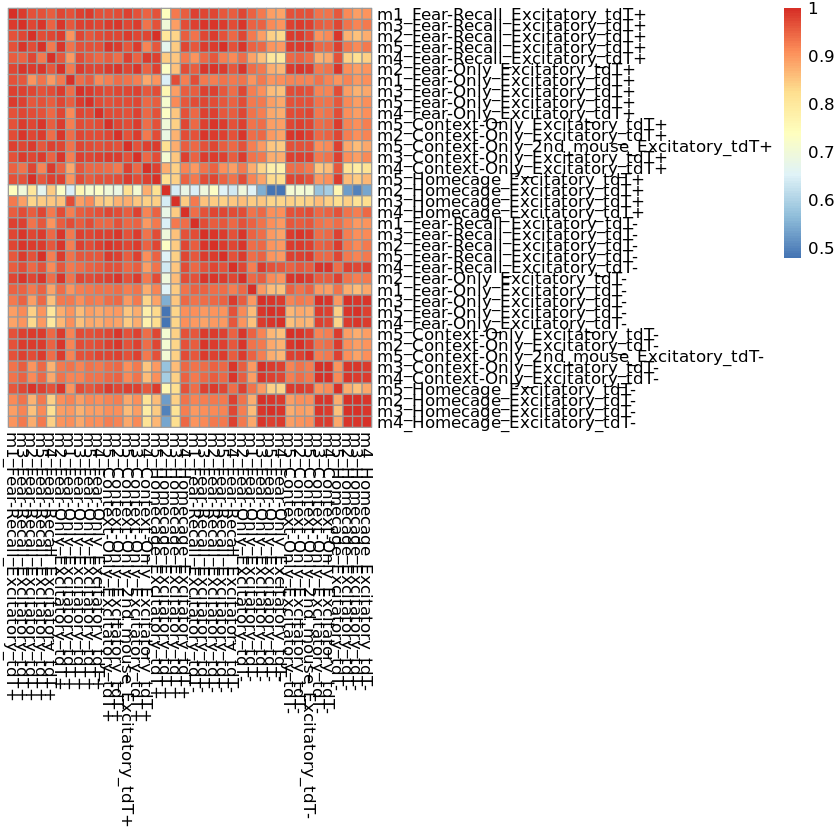

In [26]:
cortest <- pheatmap(test, cluster_cols = FALSE, cluster_rows = FALSE)

In [27]:
save_pheatmap(cortest, filename='ExcitatorySampleCorrelation.png', width = 1500, height=1500)

png 
  2

<br>
Now we filter to get rid of lowly expressed genes.
<br>

In [28]:
# look at Limma Users page 71-72 (pdf) 70-71 (document)
bulk_glut <- DGEList(counts = pseudobulk[, excitatory_pseudobulk.idx])
bulk_glut <- bulk_glut[chen.genefilter,] # filter out the genes expressed in less than 10 cells but after loading the data
# this preserves the library size which we need for calculating normfactors : https://support.bioconductor.org/p/116351/

In [29]:
# creating a variable for plotting
group <- interaction(predictors_bulk_glut$condition, predictors_bulk_glut$TRAPed)
#group <- as.character(group)
group <- gsub(pattern = '-', replacement = '', x = group)
#group <- gsub(pattern = '.', replacement = '', x = group)
group <- as.factor(group)

In [30]:
table(group)

group
ContextOnly.negative ContextOnly.positive    FearOnly.negative 
                   5                    5                    5 
   FearOnly.positive  FearRecall.negative  FearRecall.positive 
                   5                    5                    5 
   Homecage.negative    Homecage.positive 
                   4                    4 

In [31]:
predictors_bulk_glut$group <- group 

In [32]:
# Create a table of the sum of n_cells for each group
group_sum <- predictors_bulk_glut %>%
  group_by(group) %>%
  summarise(n_cells_sum = sum(n_cells))

# Create a table of the sum of the unique replicates for each group
group_unique_sum <- predictors_bulk_glut %>%
  group_by(group) %>%
  summarise(unique_replicates_sum = n_distinct(replicate))

# Combine the two tables
group_sum_unique_sum <- left_join(group_sum, group_unique_sum, by = "group")

#write.csv(group_sum_unique_sum, 'table_ofsamplesandreplicates_in_glutamatergic_cells.csv')

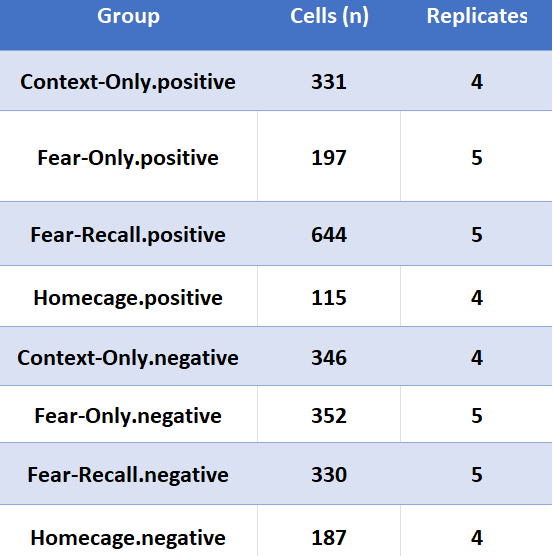

In [33]:
# now we normalize, we will try both using logCPM wth a pseudocount and the voom transformation
bulk_glut <- calcNormFactors(bulk_glut)

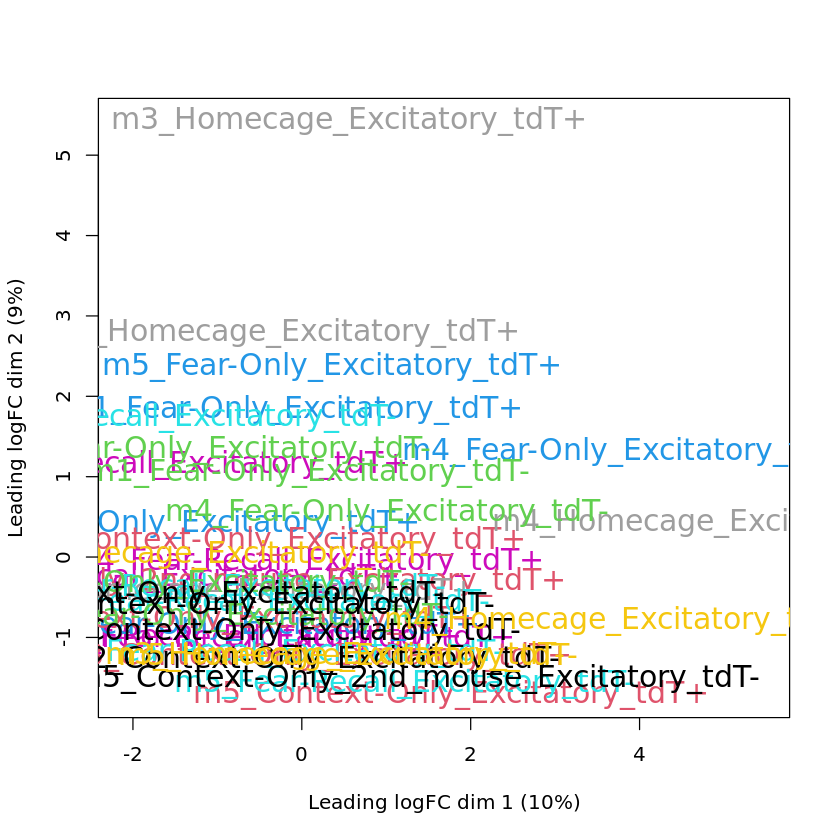

In [34]:
#logCPM trnasform before using it
plotMDS(cpm(bulk_glut, log=TRUE, prior.count=3), 
        col = as.numeric(group),
        cex = 1.5)

In [35]:
pca.raw.bulk_glut <- log2(bulk_glut$counts+0.5)
pca.bulk_glut <- PCA(t(pca.raw.bulk_glut),graph = F)

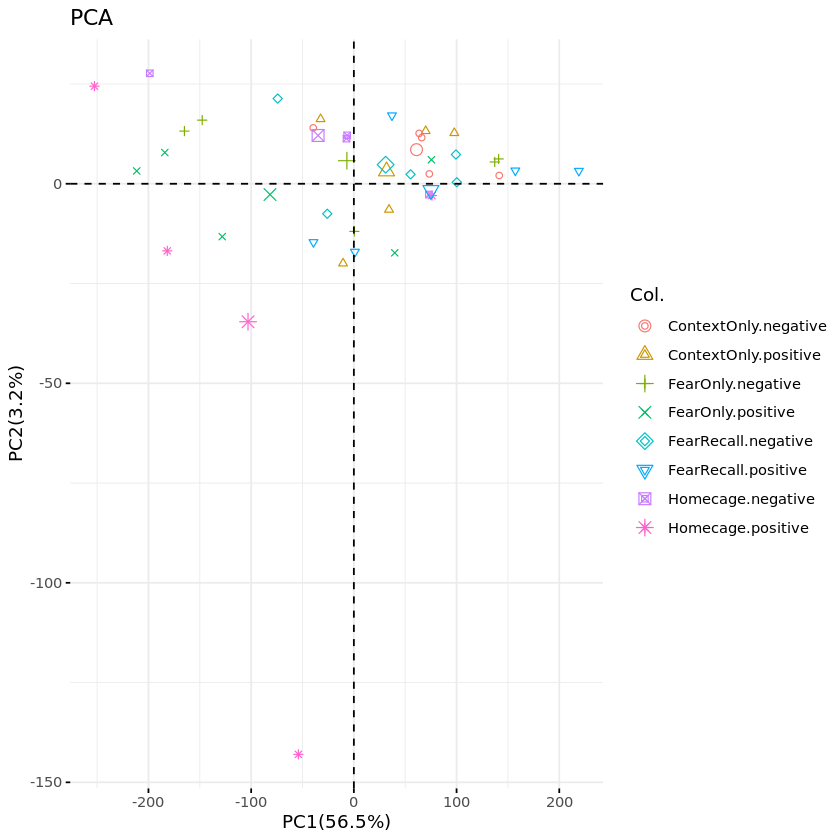

In [36]:
fviz_pca_ind(pca.bulk_glut, col.ind = group, geom ='point') +
  labs(title ="PCA", x = "PC1(56.5%)", y = "PC2(3.2%)") 

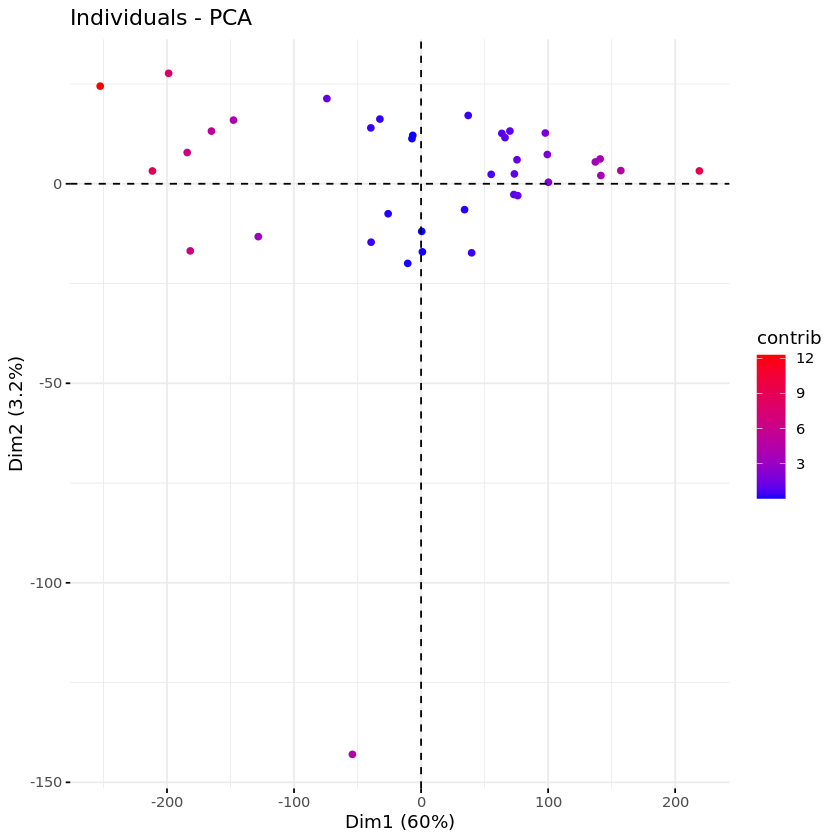

In [37]:
fviz_pca_ind(pca.bulk_glut, col.ind="contrib", geom = 'point') +
      scale_color_gradient2(low="white", mid="blue",
      high="red")

Again we see this m3_homecage as an outlier, personally I am also seeing no obvious deliniation between any of the contexts.  

Now we make the facotrs for our models, I tried using replicate and the exact conditions (like fear, exposure etc etc) but that model was overparameterized and would not fit.  The unused factors (predictors) are at the end of this document in case I find use for them.

In [38]:
# filter out lowly expressed genes again
cutoff <- 100
drop <- which(apply(cpm(bulk_glut), 1, max) < cutoff)
bulk_glut <- bulk_glut[-drop,] 
dim(bulk_glut) # number of genes left

[1] 4189   38

In [39]:
bulk_glut <- bulk_glut[rownames(bulk_glut) %in% hg_to_mm$Symbol_mm,] 
dim(bulk_glut) 

[1] 3915   38

In [40]:
# removeing the outlier

drop_thesesamples.idx <- !(colnames(pseudobulk[,excitatory_pseudobulk.idx]) %in% c('m3_Homecage_Excitatory_tdT+', 'm2_Homecage_Excitatory_tdT+') )

# use this line instead if you want to include the the pseudobulked samples
#drop_thesesamples.idx <- !(colnames(pseudobulk[,excitatory_pseudobulk.idx]) %in% c('derp') ) # for running with outliers included
bulk_glut_allsamps <- bulk_glut # save these for later
predictors_bulk_glut_allsamps <- predictors_bulk_glut

sum(drop_thesesamples.idx )

[1] 36

In [41]:
bulk_glut <- bulk_glut[,drop_thesesamples.idx ]
predictors_bulk_glut <- predictors_bulk_glut[drop_thesesamples.idx ,]

In [42]:
dim(predictors_bulk_glut)

[1] 36  9

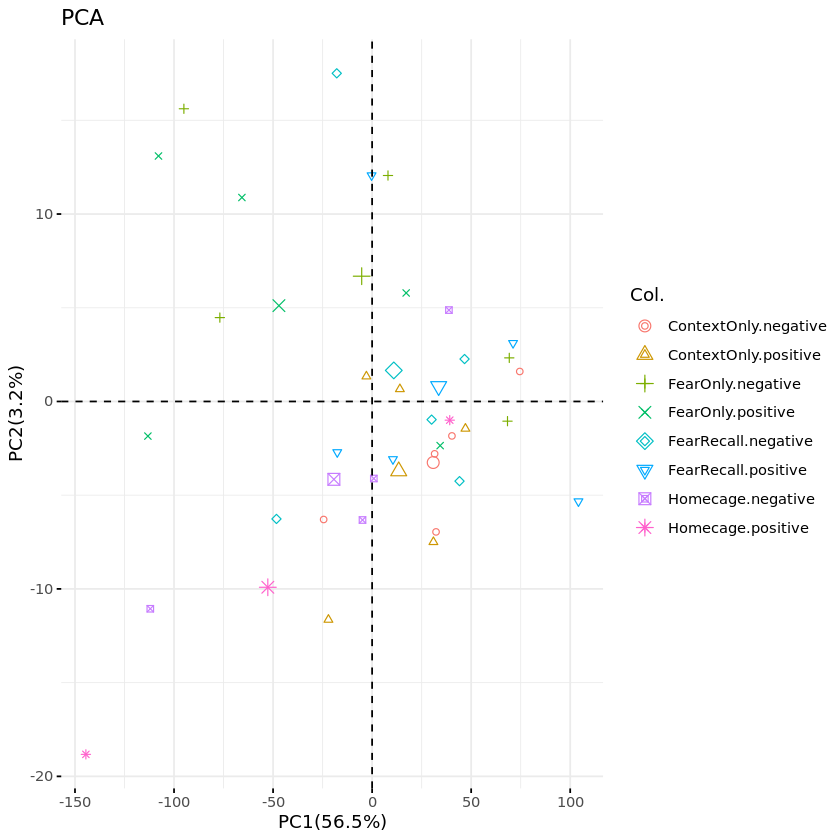

In [43]:
pca.raw.bulk_glut <- log2(bulk_glut$counts+0.5)
pca.bulk_glut <- PCA(t(pca.raw.bulk_glut),graph = F)
fviz_pca_ind(pca.bulk_glut, col.ind = predictors_bulk_glut$group, geom ='point') +
  labs(title ="PCA", x = "PC1(56.5%)", y = "PC2(3.2%)")

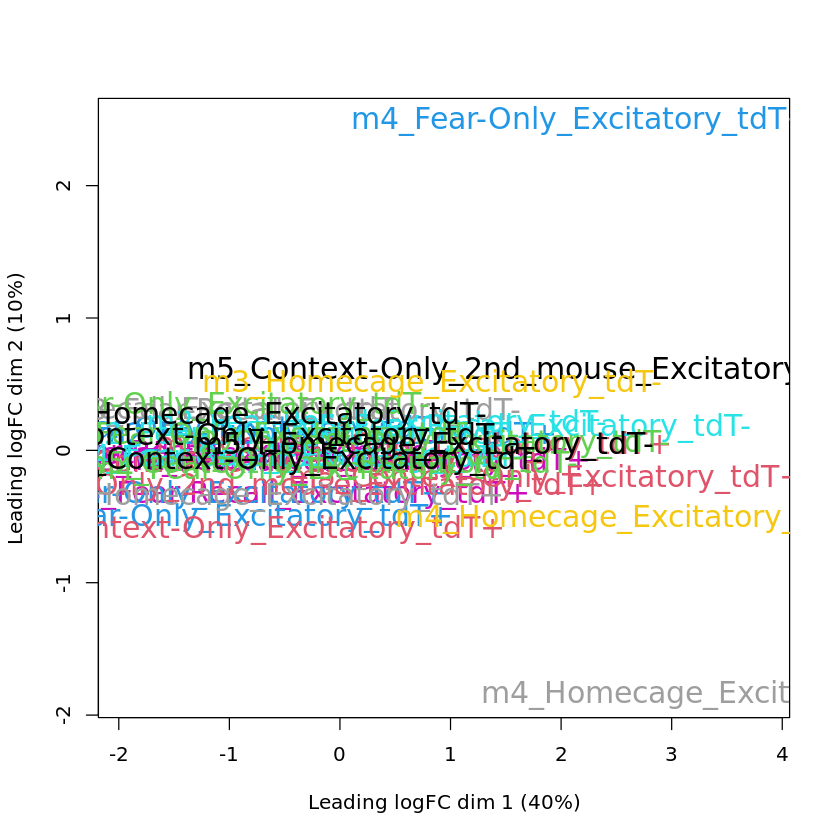

In [44]:
#logCPM trnasform before using it
plotMDS(cpm(bulk_glut, log=TRUE, prior.count=3), 
        col = as.numeric(group),
        cex = 1.5)

In [45]:
# we recalcuate normalization factors
bulk_glut <- calcNormFactors(bulk_glut)

In [46]:
# prepareing factors
condition <- predictors_bulk_glut$condition
condition <- gsub(pattern = '-', replacement = '', x = condition)
condition <- as.factor(condition)
TRAPed <- predictors_bulk_glut$TRAPed
TRAPed <- gsub(pattern = '-', replacement = '', x = TRAPed)
TRAPed <- as.factor(TRAPed)

In [47]:
# This model is based on section 9.5.3 of the Limma Users Guide 
# from page 47 of the pdf, 46 of the document 
# URL here: https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf

mm_noreps.interactions <- model.matrix(~condition*TRAPed)

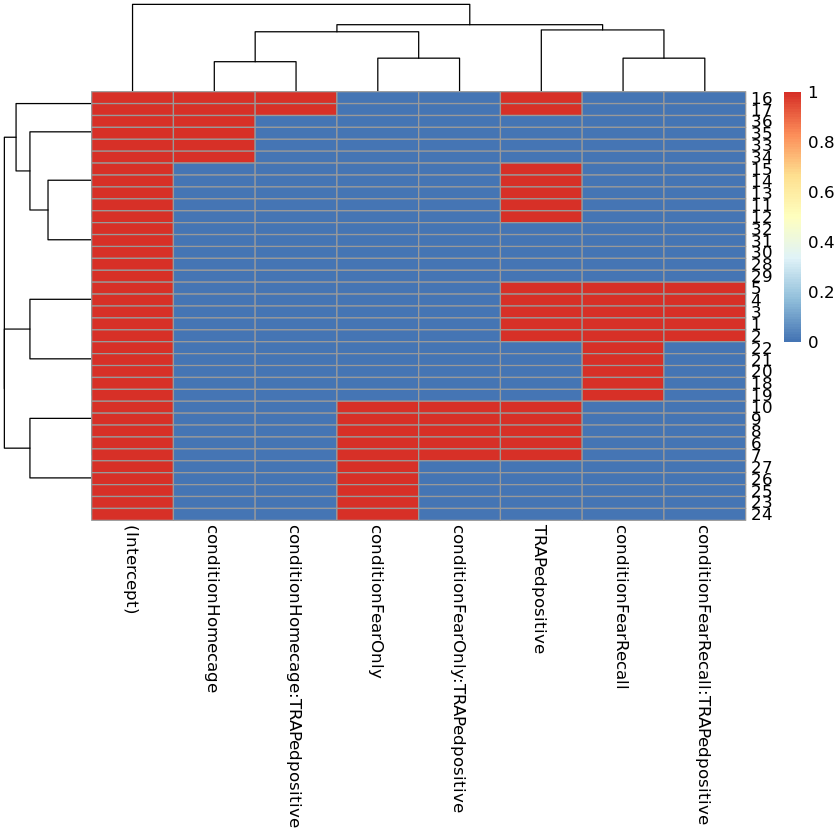

In [48]:
pheatmap(mm_noreps.interactions)

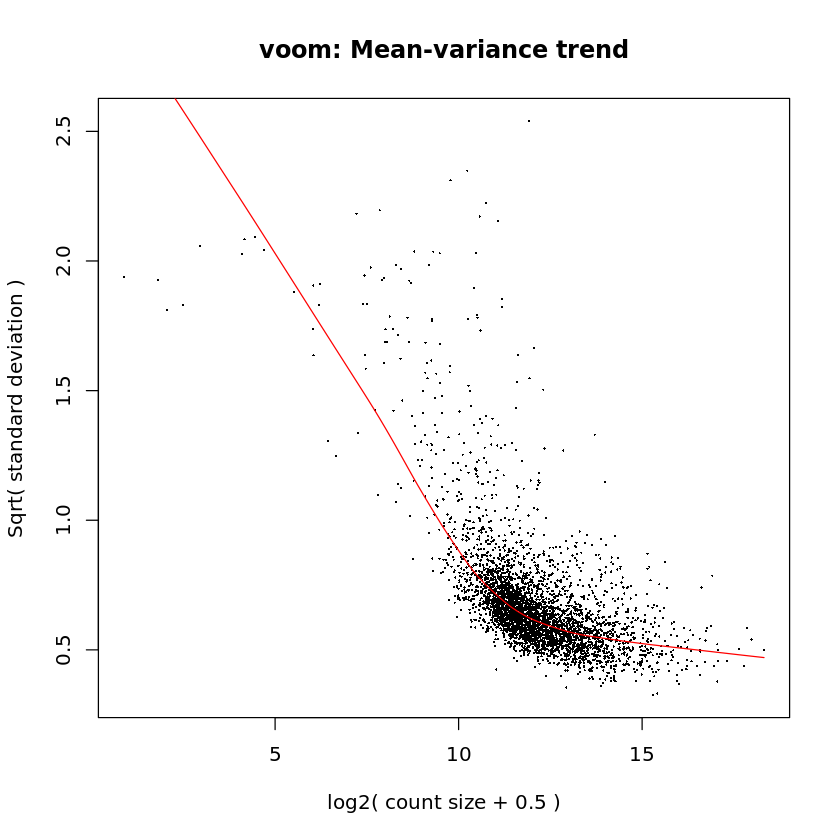

In [49]:
# make the mean varience plot (use voom)
voom.y.bulk_glut <- voom(bulk_glut, mm_noreps.interactions, plot = T) # this gives an error

png 
  2

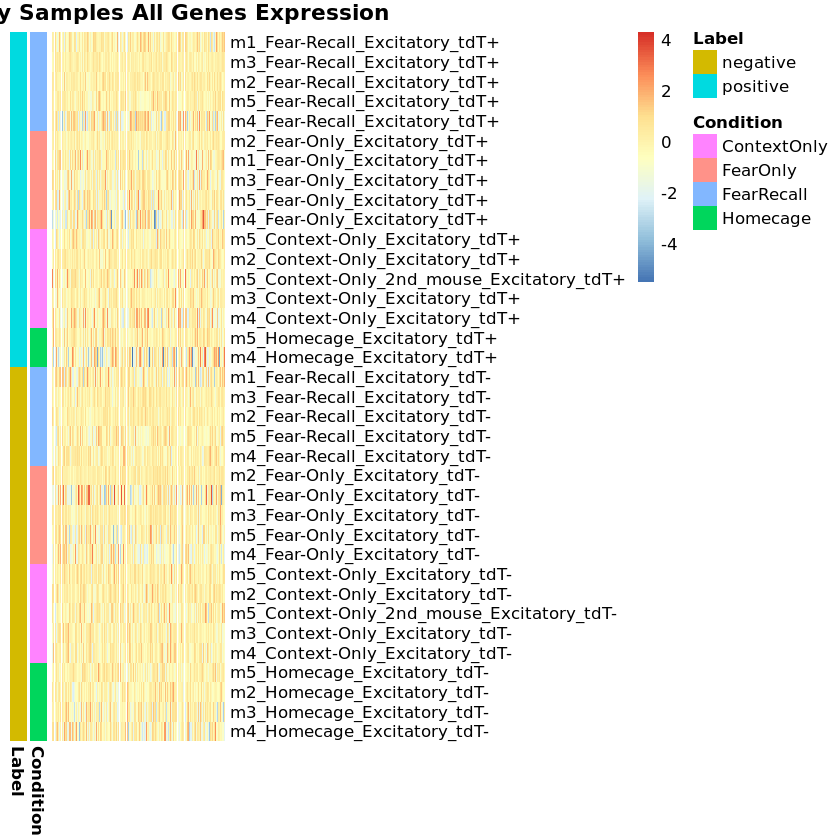

In [50]:
# one last sanity check, just looking at heatmap of expression to make sure the algorithm isn't doing somethign weird

# keep genes we used in the bulk analysis
filt <- rownames(pseudobulk) %in% rownames(bulk_glut)

# Sample Filters: 
filtered.pseudobulk <- pseudobulk[filt, excitatory_pseudobulk.idx] # remove lowly expressed genes and non excitatory samples
filtered.pseudobulk <- filtered.pseudobulk[rownames(filtered.pseudobulk) %in% hg_to_mm$Symbol_mm,] # filter to protien coding hg to mm 1 to 1 orthologs
filtered.pseudobulk <- filtered.pseudobulk[, drop_thesesamples.idx] # remove HC outliers
excitatory.libsize <- pseudobulk.librarysizes[excitatory_pseudobulk.idx] # remove nonexcitatoy for normalization library sizes (UMI count)
excitatory.libsize <- excitatory.libsize[drop_thesesamples.idx] # remove HC outliers for normalization library sizes (UMI count)

normed.filtered.pseudobulk <- pavlab.normalize(filtered.pseudobulk, UMI = excitatory.libsize ) # normalized

dat <- scale(t(normed.filtered.pseudobulk))

my_sample_row <- data.frame(Condition = condition,
                           Label = TRAPed)
row.names(my_sample_row) <- rownames(dat)

# make a heatmap
colnames(dat) <- NULL
#rownames(dat) <- NULL

temp_hm <-pheatmap(dat, cluster_rows = FALSE, cluster_cols = FALSE, main = "Excitatory Samples All Genes Expression",
        annotation_row = my_sample_row)

save_pheatmap(temp_hm, filename='ExcitatorySamplesAllGenesExpression.png', width = 1200, height=600)

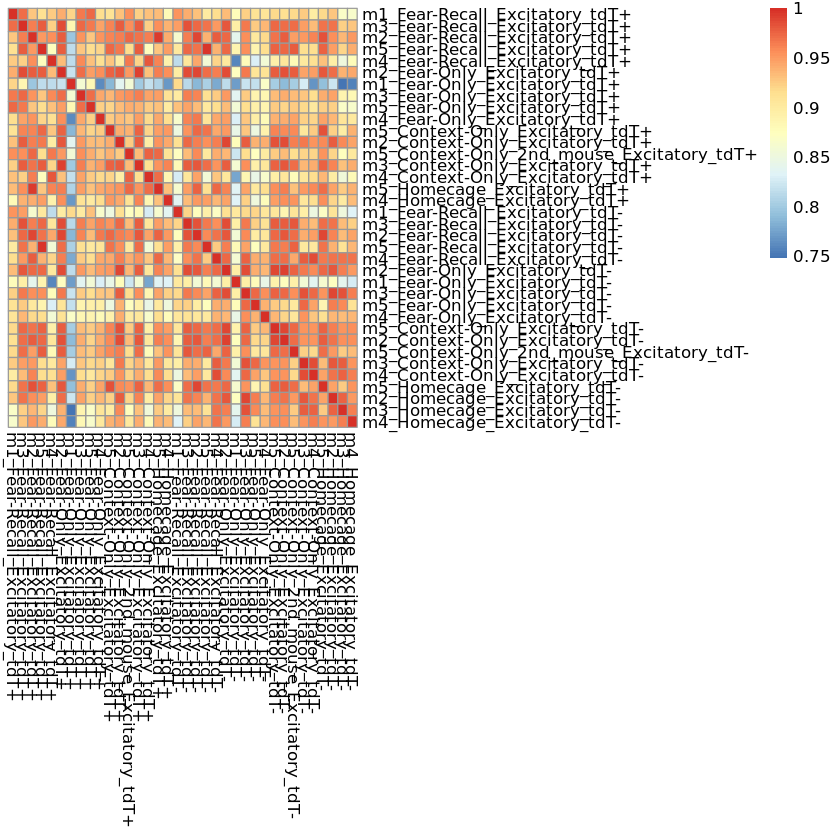

In [51]:
# produce correlation matrix before creating the DGE list
test2 <- cor(filtered.pseudobulk)
#test2 <- cor(normed.filtered.pseudobulk)

cortest2 <- pheatmap(test2, cluster_cols = FALSE, cluster_rows = FALSE)

In [52]:
save_pheatmap(cortest2, filename='Filterddata_ExcitatorySampleCorrelation.png', width = 1500, height=1500)

png 
  2

keep <- filterByExpr(bulk_glut, mm_noreps.interactions) # getting rid of lowly expressed genes
bulk_glut  <- bulk_glut[keep,,keep.lib.sizes=FALSE]
bulk_glut  <- calcNormFactors(bulk_glut, method="TMM") # normalize for composition bias,

## Doing the DEG analysis.

In [53]:
# Analysis thresholds

fdr_thresh <- 0.1

### First with LogCPM.

In [54]:
# edgeR normalization is covered on page 15 of the EdgR Users Guide pdf (same document number)
# https://bioconductor.org/packages/release/bioc/vignettes/edgeR/inst/doc/edgeRUsersGuide.pdf



# this was also used https://ucdavis-bioinformatics-training.github.io/2018-June-RNA-Seq-Workshop/thursday/DE.html
#logCPM <- cpm(bulk_glut, log=TRUE, normalized.lib.sizes = TRUE, prior.count=100)
logCPM <- cpm(bulk_glut, log=TRUE,  prior.count=1)

In [55]:
# This model is based on section 9.5.3 of the Limma Users Guide 
# from page 47 of the pdf, 46 of the document 
# URL here: https://www.bioconductor.org/packages/devel/bioc/vignettes/limma/inst/doc/usersguide.pdf

mm_noreps.interactions <- model.matrix(~condition*TRAPed)

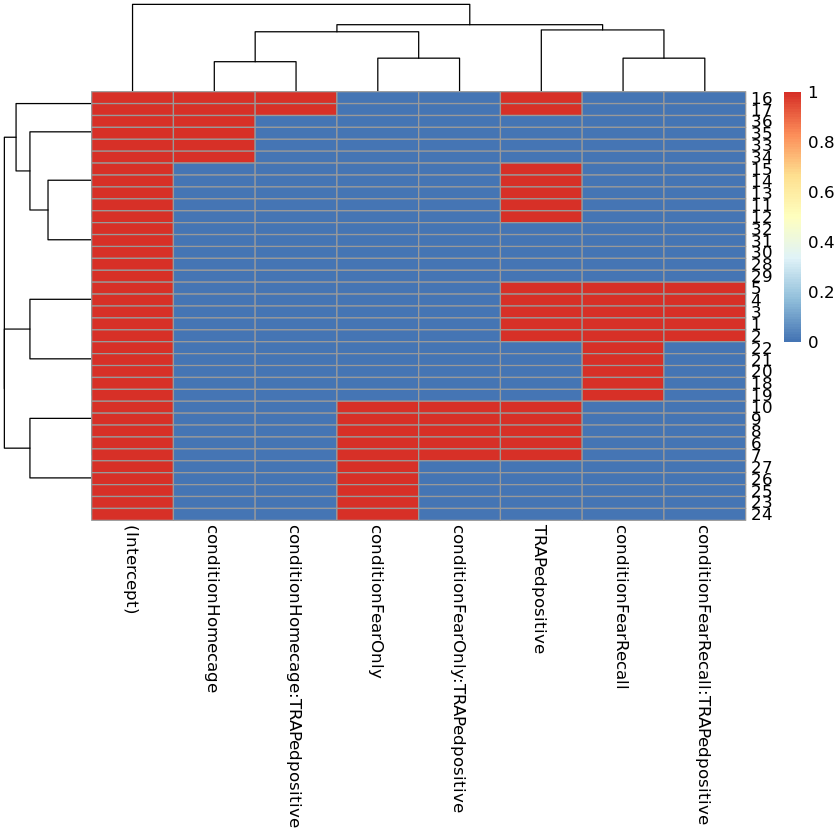

In [56]:
pheatmap(mm_noreps.interactions)

In [57]:
fit.cpm <- lmFit(logCPM, mm_noreps.interactions)
#fit.cpm <- eBayes(fit.cpm, trend=TRUE)
#topTable(fit.cpm, coef=ncol(design))

In [58]:
fit.cpm.posothervsposFR <- contrasts.fit(fit.cpm, c(0,0,-1/3,0,-1/3,-1/3,0,1))
top.cpm.posothervsposFR <- topTable(eBayes(fit.cpm.posothervsposFR), adjust.method="BH", number = 12000)

In [59]:
dim(top.cpm.posothervsposFR)

[1] 3915    6

In [60]:
c('Serinc1', 'Serinc3', 'Ptp4a1') %in% rownames(top.cpm.posothervsposFR[top.cpm.posothervsposFR$logFC>0,])

[1]  TRUE FALSE FALSE

In [61]:
dim(top.cpm.posothervsposFR[top.cpm.posothervsposFR$adj.P.Val<fdr_thresh,])

[1] 0 6

In [62]:
print(dim(top.cpm.posothervsposFR[top.cpm.posothervsposFR$adj.P.Val<fdr_thresh,]))
head(top.cpm.posothervsposFR[top.cpm.posothervsposFR$adj.P.Val<fdr_thresh,])

[1] 0 6


logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


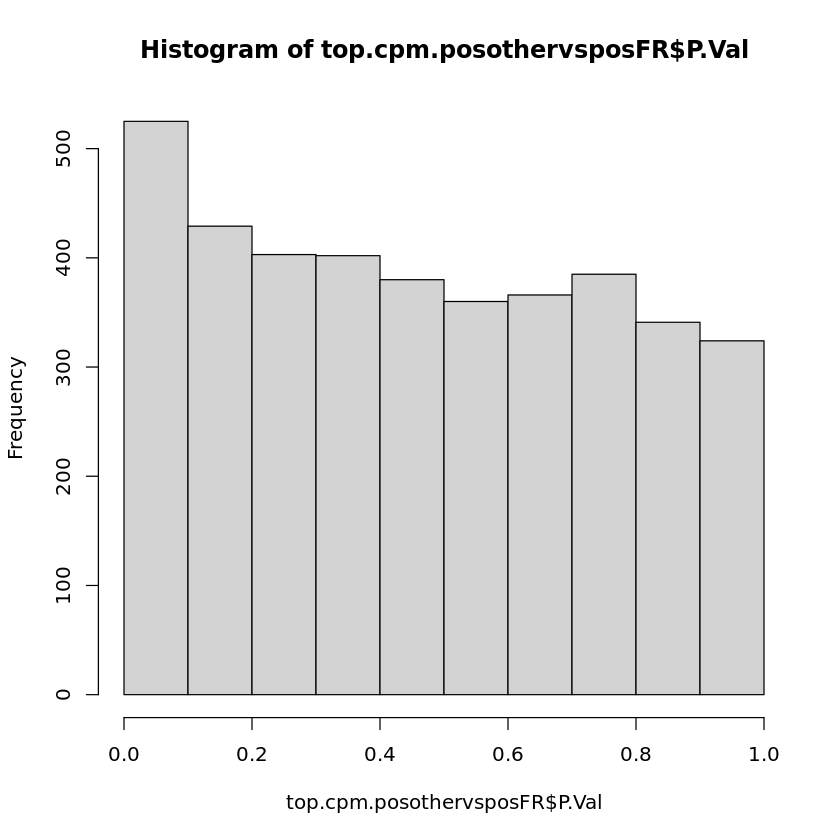

In [63]:
# 
hist(top.cpm.posothervsposFR$P.Val)

In [64]:
fit.cpm.negvspos <- contrasts.fit(fit.cpm, c(-1/4,-1/4,1/4,-1/4,1/4,1/4,-1/4,1/4))
top.cpm.negvspos <- topTable(eBayes(fit.cpm.negvspos), adjust.method="BH", number = 11000)

In [65]:
sum(top.cpm.negvspos$adj.P.Val<fdr_thresh)

[1] 3785

In [66]:
print(dim(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh,]))
head(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh,],10)

[1] 3785    6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Cdc42,-2.603215,9.913968,-37.76644,2.641227e-27,9.960550e-24,52.07092
Syt11,-2.579973,10.034605,-36.95175,5.088403e-27,9.960550e-24,51.45257
Snrpn,-2.891863,11.662601,-35.75517,1.367529e-26,1.784625e-23,50.51612
Rab3a,-2.746697,10.620805,-35.11576,2.349777e-26,2.299845e-23,50.00134
Ttc3,-2.603465,10.569383,-32.02372,3.703413e-25,2.899773e-22,47.35837
Atp5b,-2.776282,11.203210,-31.73667,4.844779e-25,3.161218e-22,47.09916
Mdh1,-2.974179,11.580160,-29.87469,2.931531e-24,1.444838e-21,45.35502
Hsp90ab1,-3.167434,11.926664,-29.86756,2.952415e-24,1.444838e-21,45.34811
Tpi1,-2.624364,10.577705,-29.73736,3.361650e-24,1.462318e-21,45.22188


In [67]:
print(dim(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh&top.cpm.negvspos$logFC>0,]))
head(top.cpm.negvspos[top.cpm.negvspos$adj.P.Val<fdr_thresh&top.cpm.negvspos$logFC>0,])

[1] 0 6


logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


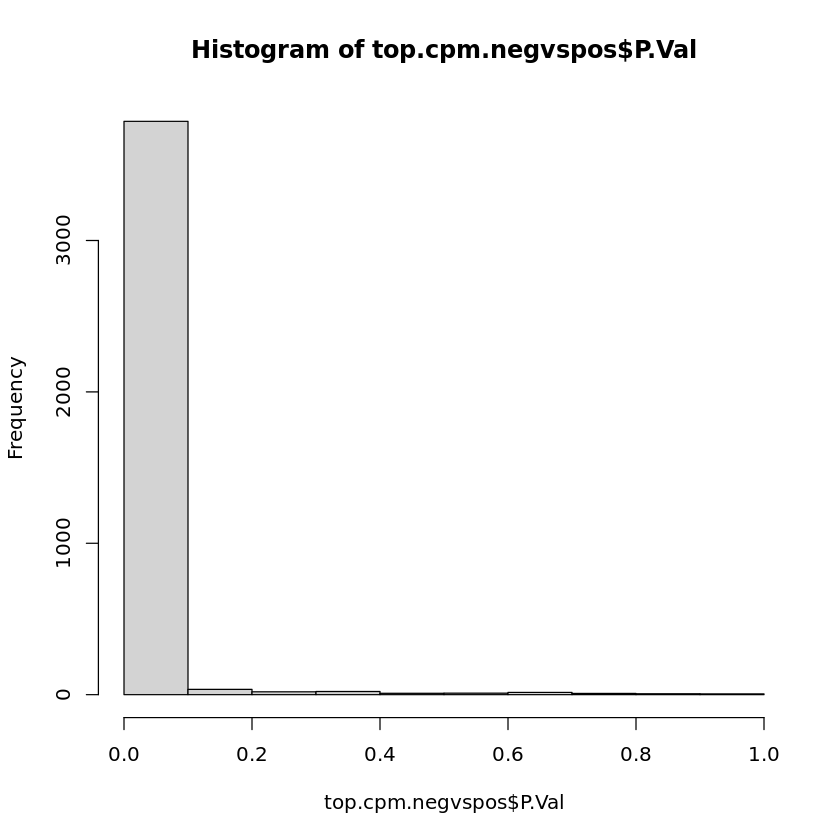

In [68]:
hist(top.cpm.negvspos$P.Val)

In [69]:
fit.cpm.FRvsALL <- contrasts.fit(fit.cpm, c(-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,1))
top.cpm.FRvsALL <- topTable(eBayes(fit.cpm.FRvsALL), adjust.method="BH", number = 11000)

In [70]:
print(dim(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh,]))
print(dim(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,]))
head(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,],10)

[1] 2286    6
[1] 6 6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Slitrk3,2.313439,4.209957,2.985776,0.005511989,0.01615227,-2.633784
Map7,1.989929,4.681537,2.630053,0.013220595,0.03183188,-3.434955
Crtac1,2.208905,5.736009,2.619570,0.013555729,0.03247900,-3.457638
Ice1,1.783795,4.471878,2.239026,0.032542049,0.06322686,-4.240095
Ablim2,1.457222,5.699952,2.185279,0.036623399,0.06950102,-4.343719
Adcyap1r1,1.511990,4.901433,2.066824,0.047270255,0.08516477,-4.565576


In [71]:
cpm.remotememorymarkers <- rownames(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,])
cpm.remotememorymarkers

[1] "Slitrk3"   "Map7"      "Crtac1"    "Ice1"      "Ablim2"    "Adcyap1r1"

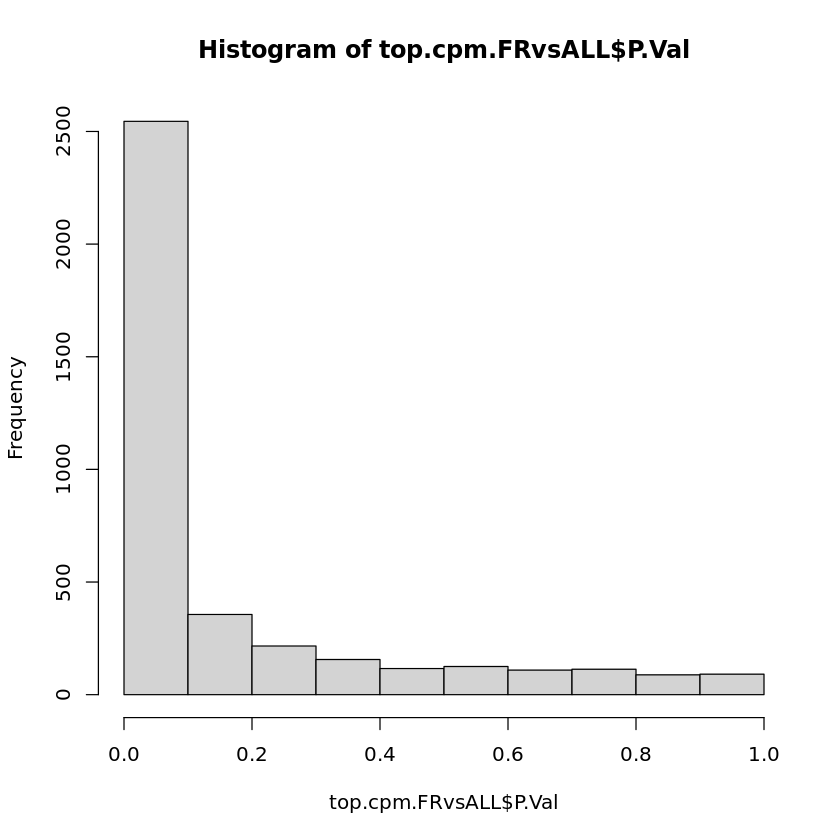

In [72]:
hist(top.cpm.FRvsALL$P.Val)

###  Now with the Voom transform.

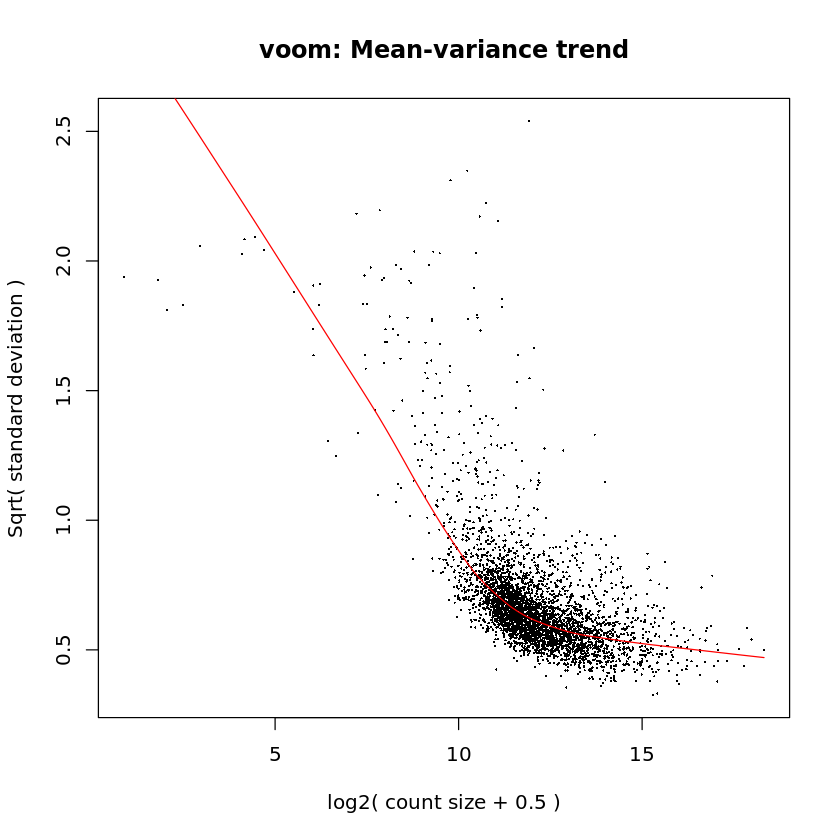

In [73]:
# Fro user guide on page 72 section 15: "When the library sizes are quite variable between samples,
# then the voom approach is theoretically more powerful than limma-trend."
# As single cell is notoriously variable (drop out etc) this seems appropriate
#voom.y.bulk_glut <- voom(bulk_glut, mm_noreps.interactions, plot = T) # this gives an error
voom.y.bulk_glut <- voom(bulk_glut, mm_noreps.interactions, plot = T) # this gives an error

I tried controlling for replicates but that seems to produce over parameterized models.  Paul asked me to do positives vs negatives as well as the.  This explanation of 2x4 design will help understand.

In [74]:
fit.voom <- lmFit(voom.y.bulk_glut, mm_noreps.interactions)
fit.voom.posothervsposFR <- contrasts.fit(fit.voom, c(0,0,-1/3,0,-1/3,-1/3,0,1))
top.voom.posothervsposFR <- topTable(eBayes(fit.voom.posothervsposFR), adjust.method="BH", number = 11000)

In [75]:
print(dim(top.voom.posothervsposFR[top.voom.posothervsposFR$adj.P.Val<fdr_thresh,]))
head(top.voom.posothervsposFR[top.voom.posothervsposFR$adj.P.Val<fdr_thresh,])

[1] 0 6


logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


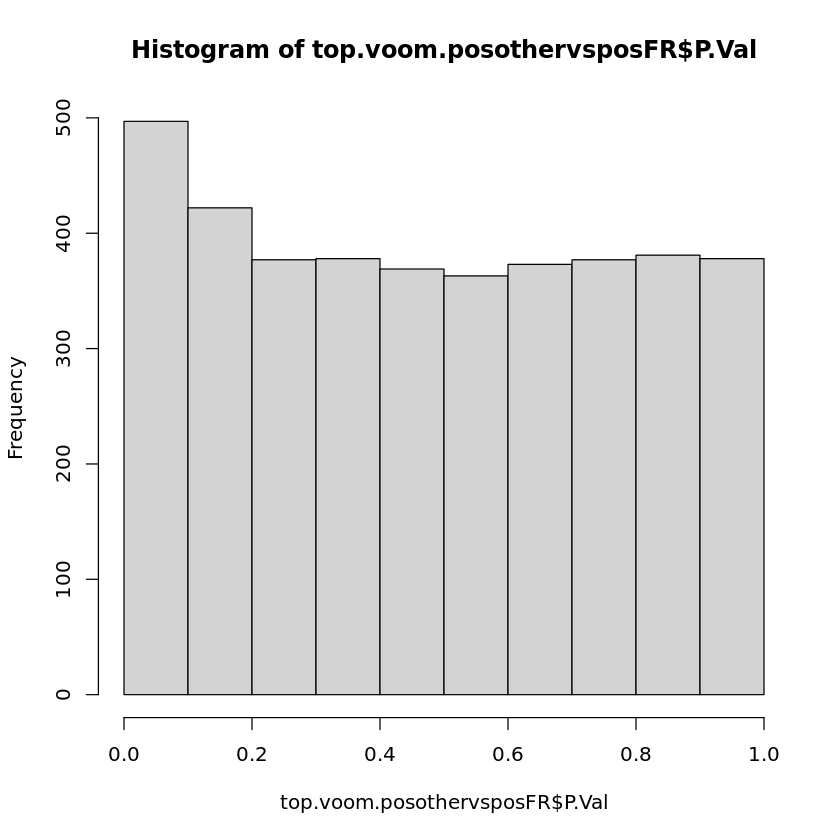

In [76]:
hist(top.voom.posothervsposFR$P.Val)

In [77]:
fit.voom.negvspos <- contrasts.fit(fit.voom, c(-1/4,-1/4,1/4,-1/4,1/4,1/4,-1/4,1/4))
top.voom.negvspos <- topTable(eBayes(fit.voom.negvspos), adjust.method="BH", number = 11000)

In [78]:
sum(top.voom.negvspos$adj.P.Val<fdr_thresh)

[1] 3800

In [79]:
print(dim(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh,]))
head(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh,],10)

[1] 3800    6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Snrpn,-2.888874,11.662606,-41.16593,1.269528e-30,1.904495e-27,59.91531
Syt11,-2.597231,10.034621,-41.21880,1.216264e-30,1.904495e-27,59.86455
Cdc42,-2.573305,9.913985,-40.99445,1.459383e-30,1.904495e-27,59.66947
Rab3a,-2.740424,10.620814,-38.38572,1.306911e-29,1.279140e-26,57.58722
Ttc3,-2.598871,10.569393,-35.49516,1.763031e-28,1.217535e-25,55.03269
Atp5b,-2.799255,11.203216,-35.43450,1.865954e-28,1.217535e-25,54.99072
Tpi1,-2.655575,10.577716,-33.77802,9.113405e-28,5.096997e-25,53.40937
Mdh1,-2.949689,11.580165,-33.53015,1.162746e-27,5.690186e-25,53.18095
Hsp90ab1,-3.193371,11.926669,-32.54451,3.116173e-27,1.355535e-24,52.20068


In [80]:
print(dim(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh&top.voom.negvspos$logFC>0,]))
head(top.voom.negvspos[top.voom.negvspos$adj.P.Val<fdr_thresh&top.voom.negvspos$logFC>0,])

[1] 0 6


logFC,AveExpr,t,P.Value,adj.P.Val,B
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>


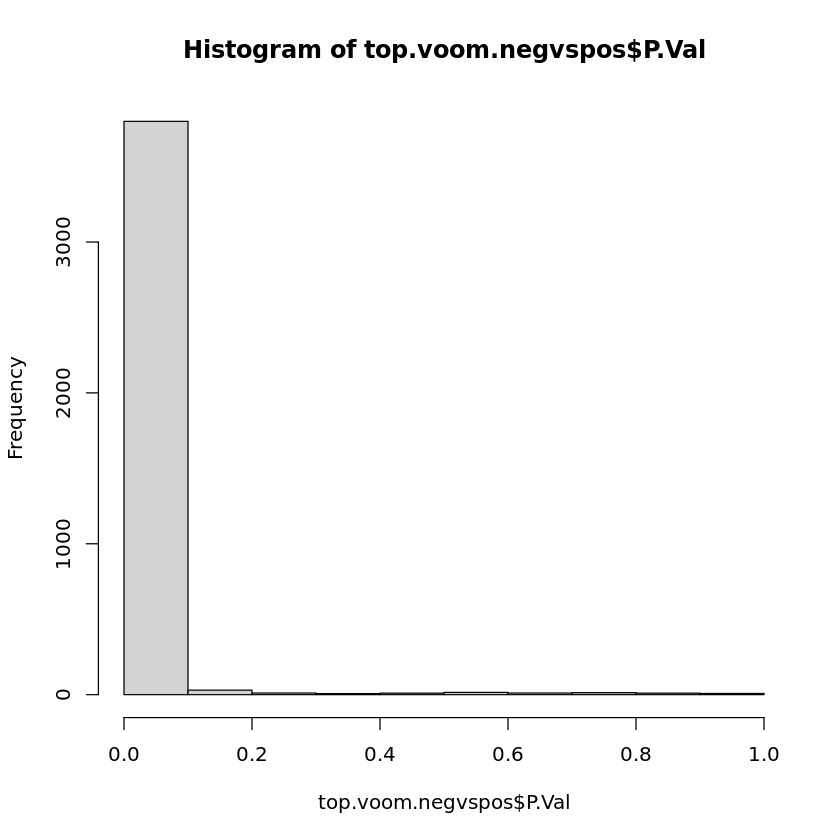

In [81]:
hist(top.voom.negvspos$P.Val)

In [82]:
fit.voom.FRvsALL <- contrasts.fit(fit.voom, c(-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,-1/7,1))
top.voom.FRvsALL <- topTable(eBayes(fit.voom.FRvsALL), adjust.method="BH", number = 11000)

In [83]:
print(dim(top.voom.FRvsALL[top.voom.FRvsALL$adj.P.Val<fdr_thresh,]))
print(dim(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]))
head(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),],10)

[1] 2520    6
[1] 12  6


,logFC,AveExpr,t,P.Value,adj.P.Val,B
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
Slitrk3,2.241447,4.210995,3.720888,0.0007140412,0.003213185,-0.4416346
Ajap1,2.924500,4.165779,2.774909,0.0089026877,0.021263678,-2.5518428
Tnnc1,4.049379,4.889123,2.815435,0.0080428161,0.019679766,-2.6428048
Slc16a2,2.094659,4.197413,2.589035,0.0140576739,0.030439241,-2.9693202
Krt12,3.627385,5.269743,2.641830,0.0123662421,0.027570523,-3.0411953
B9d1,1.409539,4.614100,2.369118,0.0236439985,0.045420144,-3.4011861
Slc2a13,1.484603,4.729929,2.327952,0.0259923954,0.048843216,-3.5253955
Car4,1.347514,4.607824,2.314980,0.0267749036,0.049916070,-3.6638212
Cpne7,1.944274,5.275490,2.151485,0.0386202304,0.066548504,-3.8540831


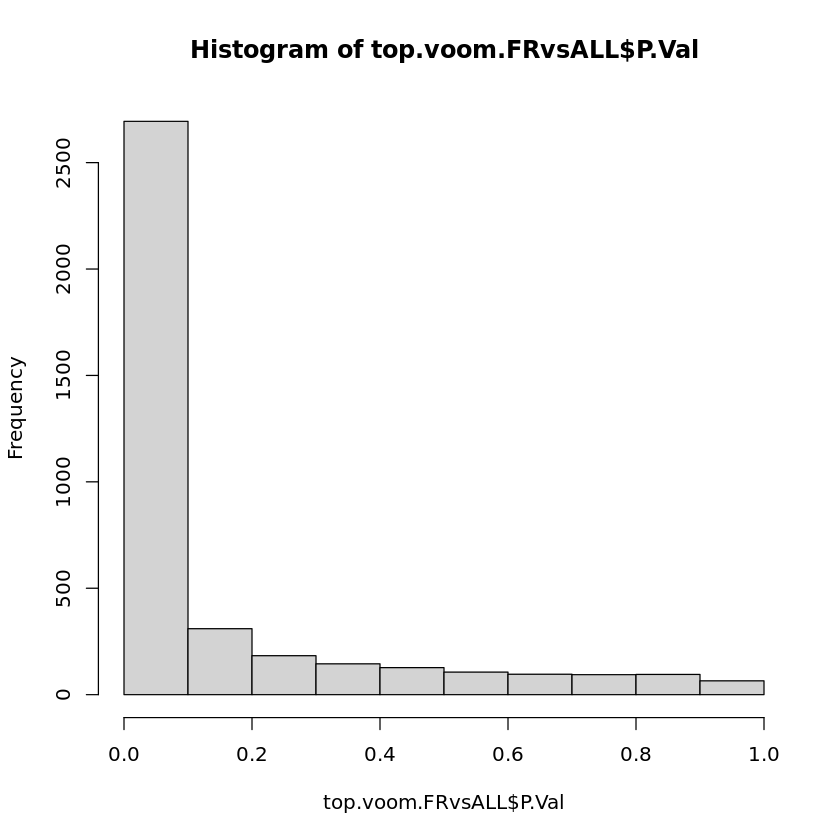

In [84]:
hist(top.voom.FRvsALL$P.Val)

In [85]:
voom.remotememorymarkers <- rownames(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),])
voom.remotememorymarkers

[1] "Slitrk3"   "Ajap1"     "Tnnc1"     "Slc16a2"   "Krt12"     "B9d1"     
 [7] "Slc2a13"   "Car4"      "Cpne7"     "Adcyap1r1" "Tenm4"     "Kcnh1"

## Visualizing our DEGs

Do we really think there is this 2000 percent increase in gene expression that we are seeing in the logFC for these genes?  Lets, find out.  First we can do it at the sample level then move on to the cell level.

In [86]:
# find the genes in the intersection of the two normalization procedures
excitatory.remotememorymarkers <- intersect(rownames(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]),
          rownames(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,]) )

excitatory.remotememorymarkers <- union(rownames(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]),
          rownames(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,]) )


excitatory.remotememorymarkers

[1] "Slitrk3"   "Ajap1"     "Tnnc1"     "Slc16a2"   "Krt12"     "B9d1"     
 [7] "Slc2a13"   "Car4"      "Cpne7"     "Adcyap1r1" "Tenm4"     "Kcnh1"    
[13] "Map7"      "Crtac1"    "Ice1"      "Ablim2"

png 
  2

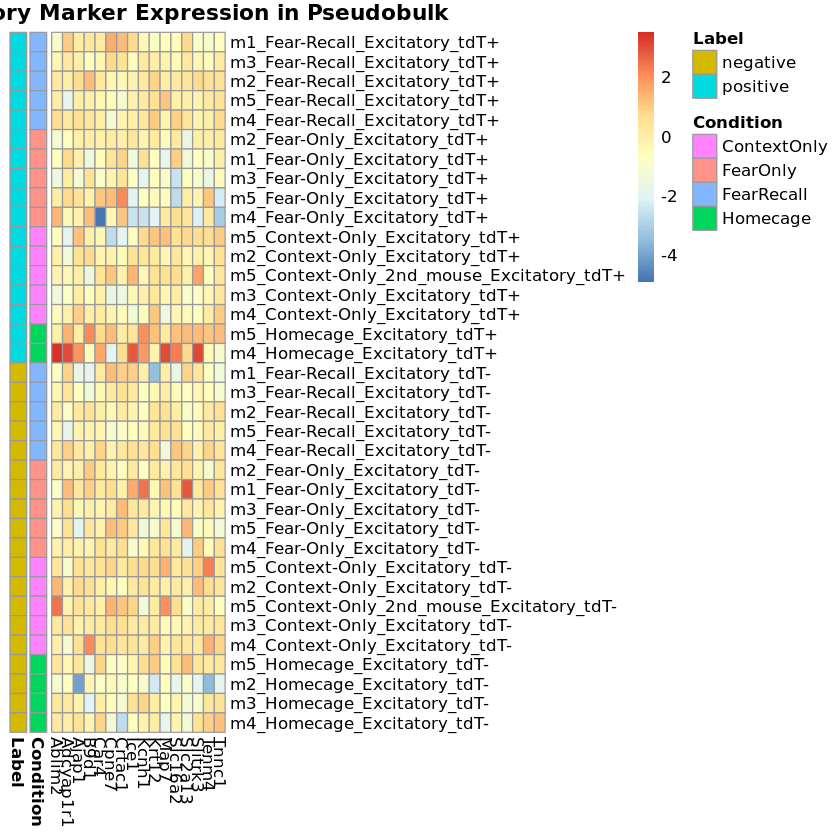

In [87]:
# one last sanity check, just looking at heatmap of expression to make sure the algorithm isn't doing somethign weird

#excitatory.remotememorymarkers <- 'Slitrk3'

# keep genes we used in the bulk analysis
filt <- rownames(pseudobulk) %in% rownames(bulk_glut)

# Sample Filters: 
filtered.pseudobulk <- pseudobulk[filt, excitatory_pseudobulk.idx] # remove lowly expressed genes and non excitatory samples
filtered.pseudobulk <- filtered.pseudobulk[rownames(filtered.pseudobulk) %in% hg_to_mm$Symbol_mm,] # filter to protien coding hg to mm 1 to 1 orthologs
filtered.pseudobulk <- filtered.pseudobulk[, drop_thesesamples.idx] # remove HC outliers
excitatory.libsize <- pseudobulk.librarysizes[excitatory_pseudobulk.idx] # remove nonexcitatoy for normalization library sizes (UMI count)
excitatory.libsize <- excitatory.libsize[drop_thesesamples.idx] # remove HC outliers for normalization library sizes (UMI count)

normed.filtered.pseudobulk <- pavlab.normalize(filtered.pseudobulk, UMI = excitatory.libsize ) # normalized

dat <- scale(t(normed.filtered.pseudobulk))
#dat <- t(normed.filtered.pseudobulk)

my_sample_row <- data.frame(Condition = condition,
                           Label = TRAPed)
row.names(my_sample_row) <- rownames(dat)

# make a heatmap
dat <- dat[, colnames(dat) %in% excitatory.remotememorymarkers]

#rownames(dat) <- NULL

temp_hm <-pheatmap(dat, cluster_rows = FALSE, cluster_cols = FALSE, main = "Remote Memory Marker Expression in Pseudobulk",
        annotation_row = my_sample_row)

save_pheatmap(temp_hm, filename='RemoteMemoryMarkersExpressionSampleLevel.png', width = 1200, height=600)

#### Keeping the homecage samples destroys all DEGs at these thresholds

I also redid the analysis keeping in the HC mice I removed as they seemed to possibly be outliers.  Doing this results in no upregulated DEGs in the logCPM transform but voom transform yeild two genes *Serinc5* and *Erap1*, which if plotted do not show a distinct pattern either.

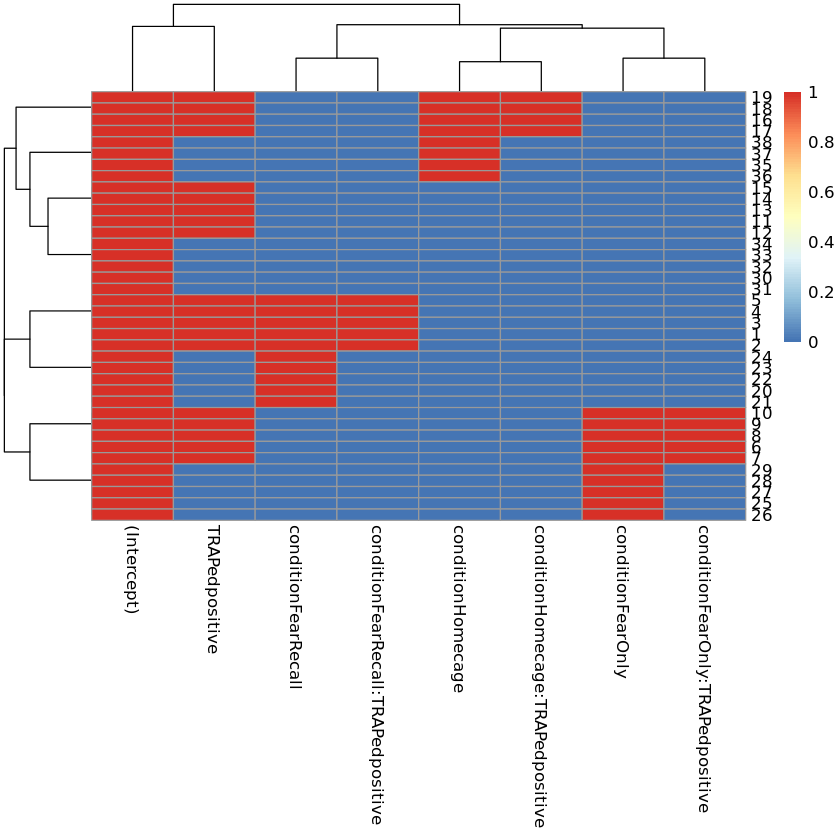

In [90]:
#

# prepareing factors
condition <- predictors_bulk_glut_allsamps$condition
condition <- gsub(pattern = '-', replacement = '', x = condition)
condition <- as.factor(condition)
TRAPed <- predictors_bulk_glut_allsamps$TRAPed
TRAPed <- gsub(pattern = '-', replacement = '', x = TRAPed)
TRAPed <- as.factor(TRAPed)


# making design matrix
mm_noreps.interactions_allsamps <- model.matrix(~condition*TRAPed)
pheatmap(mm_noreps.interactions_allsamps)

In [91]:
#logcpm
logCPM <- cpm(bulk_glut_allsamps, log=TRUE,  prior.count=1)
fit.cpm <- lmFit(logCPM, mm_noreps.interactions_allsamps)
fit.cpm.FRvsALL <- contrasts.fit(fit.cpm, c(-1/7,-1/7,-1/7,1,-1/7,-1/7,-1/7,-1/7))
top.cpm.FRvsALL <- topTable(eBayes(fit.cpm.FRvsALL), adjust.method="BH", number = 11000)

[1] 0 6


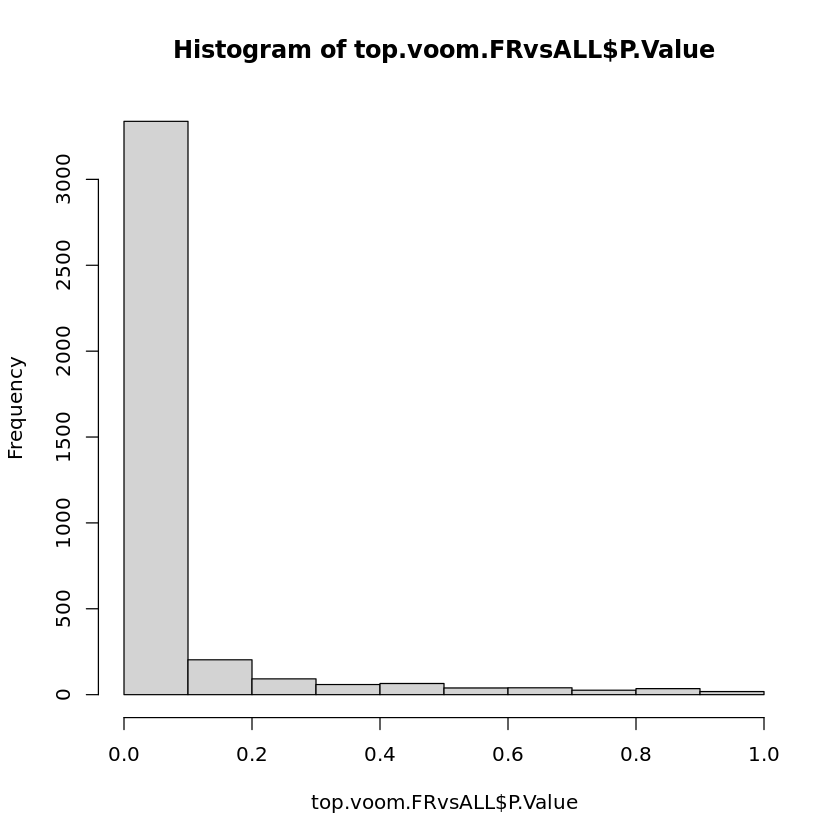

In [106]:
print(dim(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]))
hist(top.voom.FRvsALL$P.Value)

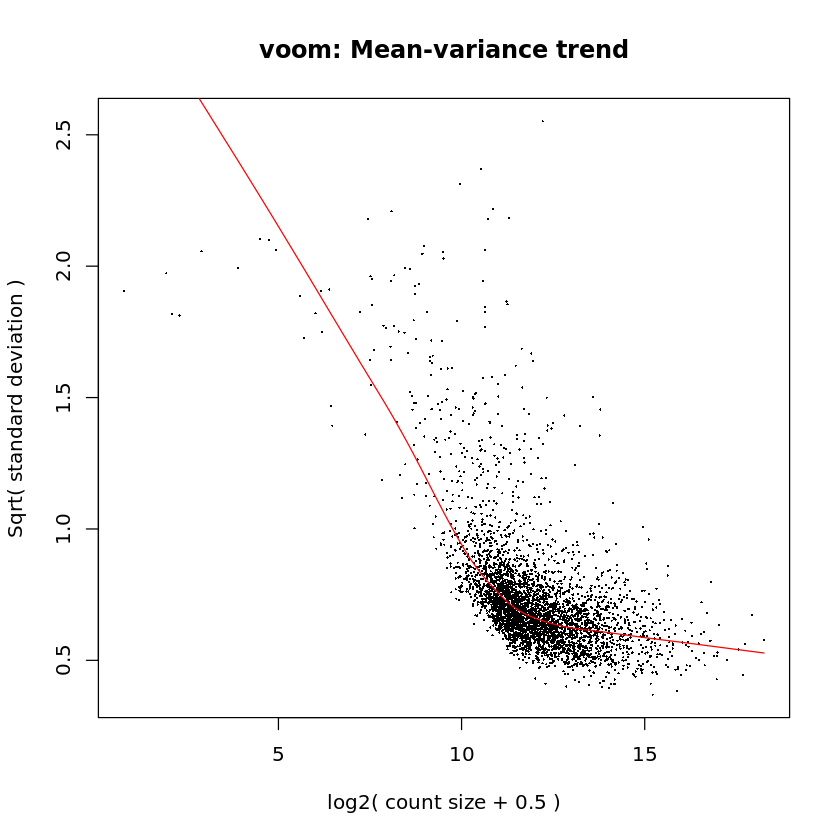

In [92]:
#voom
voom.y.bulk_glut <- voom(bulk_glut_allsamps, mm_noreps.interactions_allsamps, plot = T) 
fit.voom <- lmFit(voom.y.bulk_glut, mm_noreps.interactions_allsamps)
fit.voom.FRvsALL <- contrasts.fit(fit.voom, c(-1/7,-1/7,-1/7,1,-1/7,-1/7,-1/7,-1/7))
top.voom.FRvsALL <- topTable(eBayes(fit.voom.FRvsALL), adjust.method="BH", number = 11000)

[1] 0 6


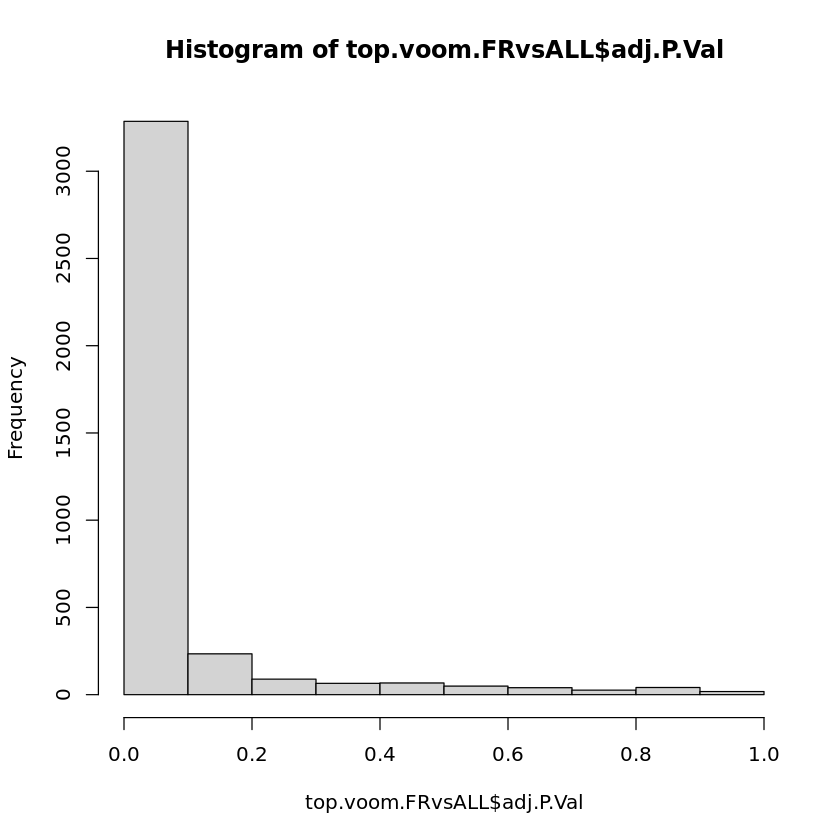

In [107]:
print(dim(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]))
hist(top.voom.FRvsALL$adj.P.Val)

In [95]:
allsampsmarkers <- union(rownames(top.voom.FRvsALL[(top.voom.FRvsALL$logFC>0)&(top.voom.FRvsALL$adj.P.Val<fdr_thresh),]),
          rownames(top.cpm.FRvsALL[top.cpm.FRvsALL$adj.P.Val<fdr_thresh&top.cpm.FRvsALL$logFC>0,]) )

length(allsampsmarkers)

In [95]:
# # plotting bullshit
# excitatory.libsize <- pseudobulk.librarysizes[excitatory_pseudobulk.idx] # remove nonexcitatoy for normalization library sizes (UMI count)

# normed.pseudobulk <- pavlab.normalize(pseudobulk[,excitatory_pseudobulk.idx], UMI = excitatory.libsize ) # normalized

# dat <- scale(t(normed.pseudobulk))
# #dat <- t(normed.filtered.pseudobulk)

# my_sample_row <- data.frame(Condition = condition,
#                            Label = TRAPed)
# row.names(my_sample_row) <- rownames(dat)

# # make a heatmap
# dat <- dat[, colnames(dat) %in% allsampsmarkers]



# # plotting gene expression per sample
# temp_hm <-pheatmap(dat, cluster_rows = FALSE, cluster_cols = FALSE, main = "Remote Memory Marker Expression in Pseudobulk (All Samples Included)",
#         annotation_row = my_sample_row)

# save_pheatmap(temp_hm, filename='NoSamplesRemoved_RemoteMemoryMarkersExpressionSampleLevel_.png', width = 1200, height=600)

Warning message in min(x, na.rm = T):
"no non-missing arguments to min; returning Inf"
Warning message in max(x, na.rm = T):
"no non-missing arguments to max; returning -Inf"


ERROR: Error in seq.default(min(x, na.rm = T), max(x, na.rm = T), length.out = n + : 'from' must be a finite number


**------------------------JUNK CODE BELOW---------------**

In [88]:
controlcontrasts <- c(fit_FRvsNR = c(0,0,0,0,0,-1,1,0),
  fit_FRvsHC = c(0,0,0,0,0,0,1,-1),
  fit_FRvsNF = c(0,0,0,0,-1,0,1,0) )

In [89]:
# Last, the remaining DEGs must pass a permutation test in which the training labels are shuffled and a distribution of log2FC 
# is computed based on these labels. The true observed logFC must be above the 95th percentile of the distribution of 
# the shuffled distribution. After placing these constraints, 99 genes remain from the original list of 1,291.

First Attempt at gettin an FR unique list, gives us 100 DEGs which don't appear in the lsit of all 

In [90]:
FR_unique <- top_FR_posvsneg[!(rownames(top_FR_posvsneg) %in% rownames(top_posvsneg)),]
dim(FR_unique)
head(FR_unique)

ERROR: Error in eval(expr, envir, enclos): object 'top_FR_posvsneg' not found


In [ ]:
# normalization methods, we wont even use these

# paul prefers a log base that's easy to do headmath with so no eulers numebr
pseudocount_log2p1_transform <- function(x, scale_factor = 10^4, UMI.provided = NULL){
  if(is.null(UMI.provided)){
    counts <- sum(x)}else{
      counts <- UMI.provided
    }
  x <- (x+1)/counts
  x <- x/scale_factor
  return(log2(x))
}

pavlab.normalize <- function(df, UMI = NULL){
  df.cols <- colnames(df)
  df.rows <- rownames(df)
  if( is.null(UMI)){
    df <- data.frame(apply(df,  MARGIN = 2, pseudocount_log2p1_transform))
  }else{
#
   df[] <- Map(pseudocount_log2p1_transform, df, UMI.provided = UMI)
  
  }
  colnames(df) <- df.cols
  rownames(df)<- df.rows
  return(df)
}

In [ ]:
# usused factors (predictors)
replicate <- predictors_bulk_glut$replicate
replicate <- gsub(pattern = '-', replacement = '', x = replicate)
replicate <- as.factor(replicate)
environment_exposure <- predictors_bulk_glut$environment_exposure
environment_exposure <- gsub(pattern = '-', replacement = '', x = environment_exposure)
environment_exposure <- as.factor(environment_exposure)
fear <- predictors_bulk_glut$fear
fear <- gsub(pattern = '-', replacement = '', x = fear)
fear <- as.factor(fear)
recall <- predictors_bulk_glut$recall
recall <- gsub(pattern = '-', replacement = '', x = recall)
recall <- as.factor(recall)

In [ ]:
gene_filter <-function(df_toptable){
    # DEG lsit from a topTable function, takes df of any size
    return(df_toptable[ abs(df_toptable$logFC)>0.3 & df_toptable$adj.P.Val<fdr_thresh,])
    }